<a href="https://colab.research.google.com/github/leofire19/bangkit_finalproject/blob/master/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

import numpy as np 
import pandas as pd 

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns

# from PIL import Image
# from PIL.ImageOps import invert
# import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from shutil import copyfile

from IPython import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Download dataset to /content/datasets

In [2]:
# Getting the image dataset: Edible wild plants by gverzea on Kaggle
# Kaggle credentials
!mkdir /root/.kaggle
!echo '{"username":"leofiro","key":"5c8b9307b19cbfaa67788390ec75dd15"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Kaggle dataset
!kaggle datasets download -d gverzea/edible-wild-plants

!ls

#unzipping the zip files and deleting the zip files
!unzip -q \*.zip  && rm *.zip

 98% 754M/766M [00:16<00:00, 35.9MB/s]
100% 766M/766M [00:16<00:00, 49.5MB/s]
edible-wild-plants.zip	sample_data


In [15]:
!pwd
!rm -r datasets/dataset/Sunflower/
!rm -r datasets/dataset/'Daisy Fleabane'
!rm -r datasets/dataset/Dandellion
!rm -r datasets/dataset-test/Sunflower/
!rm -r datasets/dataset-test/'Daisy Fleabane'
!rm -r datasets/dataset-test/Dandellion

!ls datasets/dataset-test/

/content
rm: cannot remove 'datasets/dataset-test/Sunflower/': No such file or directory
rm: cannot remove 'datasets/dataset-test/Daisy Fleabane': No such file or directory
rm: cannot remove 'datasets/dataset-test/Dandellion': No such file or directory
 Alfalfa	       'Field Pennycress'    Pickerelweed
 Asparagus	        Fireweed	    'Pineapple Weed'
'Blue Vervain'	       'Forget Me Not'	    'Prickly Pear Cactus'
'Broadleaf Plantain'   'Garlic Mustard'     'Purple Deadnettle'
'Bull Thistle'	        Harebell	    'Queen Annes Lace'
 Cattail	        Henbit		    'Red Clover'
 Chickweed	       'Herb Robert'	    'Sheep Sorrel'
 Chicory	       'Japanese Knotweed'  'Shepherds Purse'
 Cleavers	       'Joe Pye Weed'	    'Spring Beauty'
 Coltsfoot	        Knapweed	    'Supplejack Vine'
'Common Sow Thistle'    Kudzu		    'Tea Plant'
'Common Yarrow'        'Lambs Quarters'      Teasel
 Coneflower	        Mallow		     Toothwort
'Creeping Charlie'      Mayapple	    'Vervain Mallow'
'Crimson Clover'  

In [4]:
# Checking what's inside the dataset
labels = os.listdir('/content/datasets/dataset/')

'''# Automating label print
labels_nospace = []

for label in labels:
  labels_nospace.append(label.replace(" ", ""))

#print(type(labels_nospace))

labels_list = '_traindir\n'.join(labels_nospace)

print(labels_list)'''

'# Automating label print\nlabels_nospace = []\n\nfor label in labels:\n  labels_nospace.append(label.replace(" ", ""))\n\n#print(type(labels_nospace))\n\nlabels_list = \'_traindir\n\'.join(labels_nospace)\n\nprint(labels_list)'

# EDA

In [5]:
train_dir = '/content/datasets/dataset'
val_dir = '/content/datasets/dataset-test'

In [6]:
labels = os.listdir(train_dir)

train_files = {}
for lab in labels:
  train_files[lab] = os.listdir(os.path.join(train_dir, lab))

Total files for each label


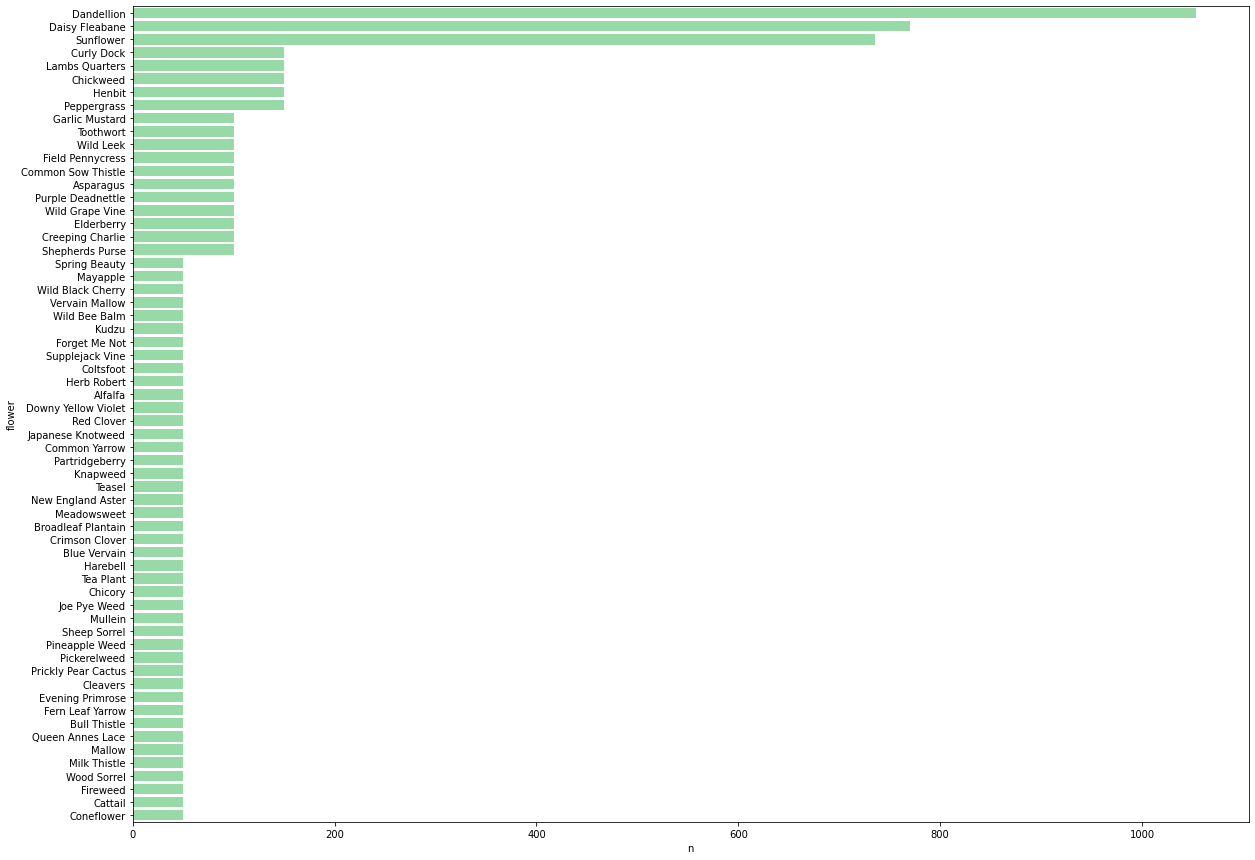

In [7]:
print('Total files for each label')
n_flower = []
for lab in labels:
  n_flower.append(len(train_files[lab]))

df_lab_flower = pd.DataFrame({
    'flower':labels,
    'n':n_flower
})

plt.figure(figsize=(20,15))
sns.set_color_codes("pastel")
sns.barplot(x="n", y="flower", data=df_lab_flower.sort_values('n',ascending=False),
            label="flower", color='g')
plt.show()

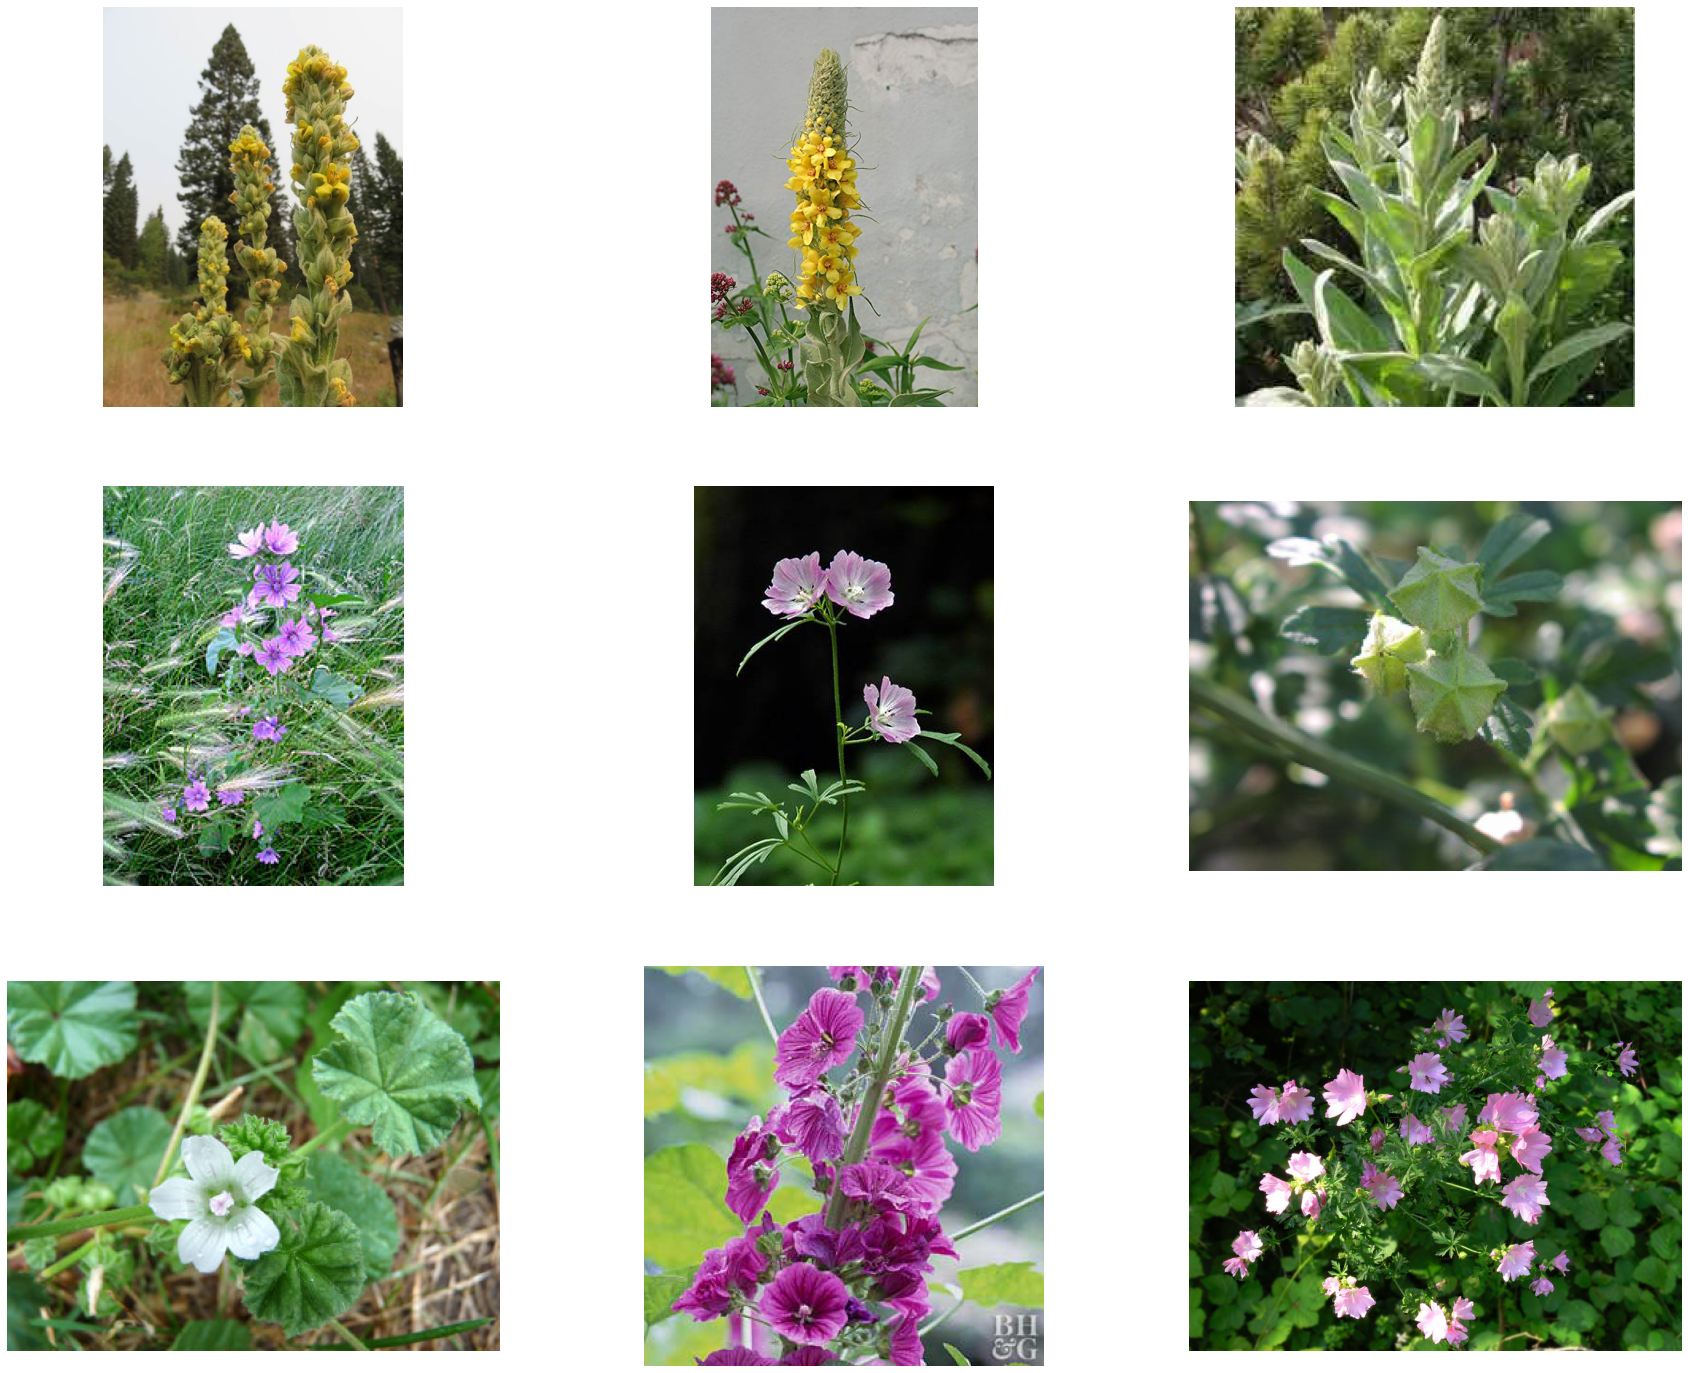

In [8]:
# Let's try visualizing some of them
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# let's try Wild Grapevine, Japanese Knotweed, Mallow
play_labels = ['Mullein', 'Vervain Mallow', 'Mallow']

pic_id = 33
pic_filenames = {}
for l in play_labels:
  ldir = os.path.join(train_dir,l)
  pic_filenames[l] = [os.path.join(ldir,fname) for fname in os.listdir(ldir)[pic_id-3:pic_id]]

plt.figure(figsize=(30,25))
cnt = 1
for label in pic_filenames:
  for f in pic_filenames[label]:
    plt.subplot(3,3,cnt)
    img = mpimg.imread(f)
    plt.imshow(img)
    plt.axis('Off')
    # plt.show()
    cnt += 1
plt.show()

## Dimensions of the images


In [9]:
x = []
y = []
for the_plant in train_files:
  """this loop took quite some time.. it reads all the images!"""
  for fname in train_files[the_plant]:
    ffname = os.path.join(train_dir, the_plant, fname)
    pimg = mpimg.imread(ffname)
    x.append(pimg.shape[:2][0])
    y.append(pimg.shape[:2][1])
dimensions = pd.DataFrame({'x':x,'y':y})
dimensions.describe()

x            y
count  6558.000000  6558.000000
mean    355.630985   421.612534
std     223.124823   256.740402
min      98.000000   128.000000
25%     222.000000   250.000000
50%     266.000000   320.000000
75%     400.000000   500.000000
max    2500.000000  2931.000000

# Data Generator

In [34]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# img_size_x = int(np.round(dimensions['x'].mean()))
# img_size_y = int(np.round(dimensions['y'].mean()))
img_size_x = 150
img_size_y = 150

train_dir = '/content/datasets/dataset'
training_datagen = ImageDataGenerator(
      rescale = 1./255,
  )
training_datagen_aug = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.20,
      height_shift_range=0.20,
      shear_range=0.20,
      zoom_range=0.20,
      horizontal_flip=True,
      fill_mode='nearest'
  )

val_dir = '/content/datasets/dataset-test'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(img_size_x, img_size_y),
	class_mode='categorical',
  batch_size=50
)

train_generator_aug = training_datagen_aug.flow_from_directory(
	train_dir,
	target_size=(img_size_x, img_size_y),
	class_mode='categorical',
  batch_size=50
)

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(img_size_x, img_size_y),
	class_mode='categorical',
  batch_size=25
)

Found 4000 images belonging to 59 classes.
Found 4000 images belonging to 59 classes.
Found 295 images belonging to 59 classes.


In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')

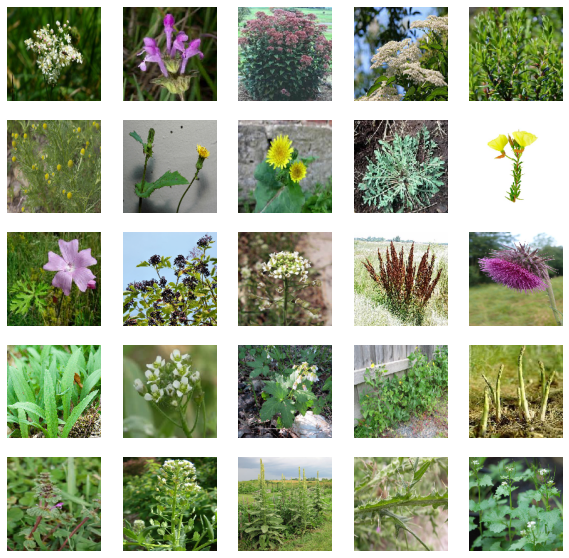

In [35]:
# Before Augmentation
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

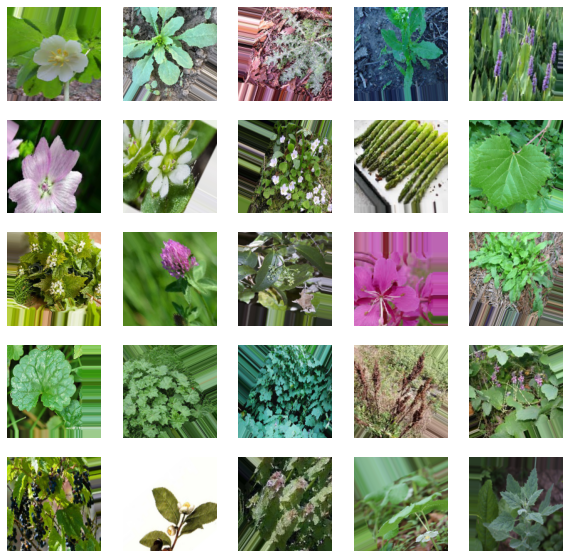

In [36]:
# After Image Augmentation
image_batch, label_batch = next(train_generator_aug)
show_batch(image_batch, label_batch)

# Baeline Model

In [18]:
def learning_curve(history,titles,legend,metrics=['accuracy','loss']):
    nplots=len(metrics)
    fig , ax = plt.subplots(1,nplots,sharex=True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    for i in range(nplots):
        ax[i].plot(history.history[metrics[i]])
        ax[i].plot(history.history['val_{}'.format(metrics[i])])
        ax[i].set(xlabel='Epoch', ylabel=metrics[i])
        ax[i].legend(legend)
        ax[i].title.set_text(titles[i])
    plt.tight_layout()
    plt.show()

In [28]:
MCP = tf.keras.callbacks.ModelCheckpoint('Best_points.h5',
                                         verbose=1,
                                         save_best_only=True,
                                         monitor='val_accuracy',
                                         mode='max')
ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                      min_delta=0,
                                      verbose=1,
                                      restore_best_weights = True,
                                      patience=10,
                                      mode='max'
                                     )
RLP = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=10,factor=0.2,
    min_lr=0.0001,verbose = 1
)
callbacks =[MCP,ES,RLP]

## Before Augmentation

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(img_size_x, img_size_y, 3),name='convolutional_layer'),
    tf.keras.layers.MaxPooling2D(2, 2,name='pooling_layer'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu',name='dense_layer'),
    tf.keras.layers.Dense(59, activation='softmax',name='output_layer')
],name='Baseline_Model')

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, 
                    epochs=25, 
                    steps_per_epoch=20, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=25,
                    callbacks=callbacks)

Model: "Baseline_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolutional_layer (Conv2D) (None, 148, 148, 128)     3584      
_________________________________________________________________
pooling_layer (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)               89718912  
_________________________________________________________________
output_layer (Dense)         (None, 59)                7611      
Total params: 89,730,107
Trainable params: 89,730,107
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 19.9091 - accuracy: 0.0280WARNING:tens

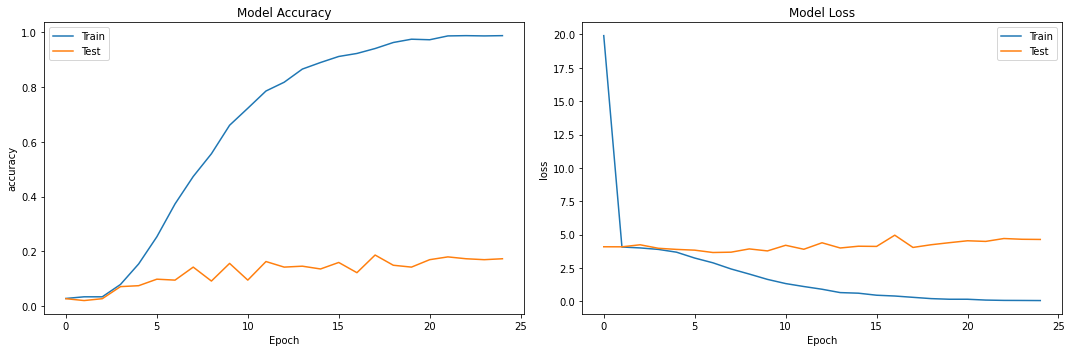

In [30]:
learning_curve(history,
               ['Model Accuracy','Model Loss'],
               legend=['Train','Test'],metrics=['accuracy','loss'])

In [31]:
print('\n# Evaluate on train data')
results = model.evaluate(train_generator)
print('train loss, train acc:', results)

print('\n# Evaluate on train data')
results = model.evaluate(validation_generator)
print('test loss, test acc:', results)


# Evaluate on train data
80/80 [==============================] - 22s 270ms/step - loss: 0.0431 - accuracy: 0.9927
train loss, train acc: [0.04307115077972412, 0.9927499890327454]

# Evaluate on train data
12/12 [==============================] - 1s 116ms/step - loss: 4.6359 - accuracy: 0.1729
test loss, test acc: [4.635853290557861, 0.1728813499212265]


## After Image Augmentation

In [39]:
model_aug = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(img_size_x, img_size_y, 3),name='convolutional_layer'),
    tf.keras.layers.MaxPooling2D(2, 2,name='pooling_layer'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu',name='dense_layer'),
    tf.keras.layers.Dense(59, activation='softmax',name='output_layer')
],name='Baseline_Model')

model_aug.summary()

model_aug.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_aug = model_aug.fit(train_generator_aug, 
                    epochs=25, 
                    steps_per_epoch=20, 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=25,
                    callbacks=callbacks)

Model: "Baseline_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolutional_layer (Conv2D) (None, 148, 148, 128)     3584      
_________________________________________________________________
pooling_layer (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)               89718912  
_________________________________________________________________
output_layer (Dense)         (None, 59)                7611      
Total params: 89,730,107
Trainable params: 89,730,107
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 23.5165 - accuracy: 0.0240WARNING:tens

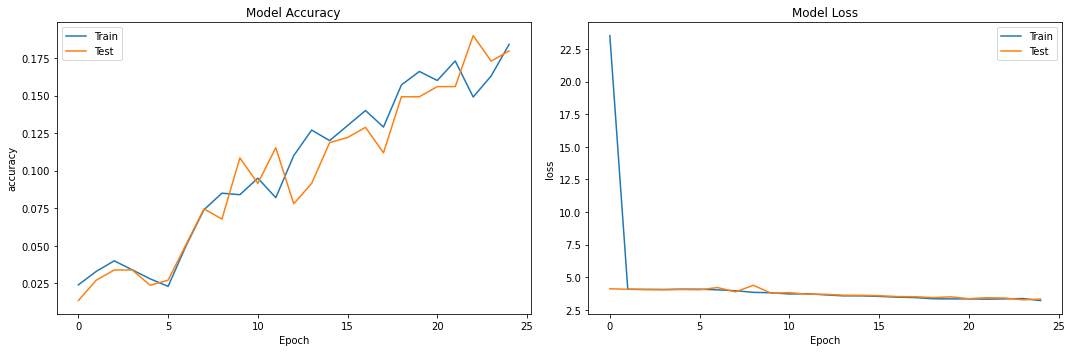

In [40]:
learning_curve(history_aug,
               ['Model Accuracy','Model Loss'],
               legend=['Train','Test'],metrics=['accuracy','loss'])

In [41]:
print('\n# Evaluate on train data')
results = model_aug.evaluate(train_generator_aug)
print('train loss, train acc:', results)

print('\n# Evaluate on train data')
results = model_aug.evaluate(validation_generator)
print('test loss, test acc:', results)


# Evaluate on train data
80/80 [==============================] - 42s 528ms/step - loss: 3.3151 - accuracy: 0.1538
train loss, train acc: [3.315131187438965, 0.1537500023841858]

# Evaluate on train data
12/12 [==============================] - 1s 118ms/step - loss: 3.3216 - accuracy: 0.1797
test loss, test acc: [3.3215997219085693, 0.17966102063655853]
